# Prática sobre "Aceleração e Eficiência"

Este caderno experimental tem por objetivo calcularmos a aceleração (*speedup*) e eficiência de uma operação quando esta pode ser calculada em paralelo. Utilizaremos como exemplo uma operação que consiste em multiplicar duas matrizes.

Empregaremos as bibliotecas `numpy` para lidar com os valores e organização dos dados e `dask` para a paralelização da operação.



## Instalação de pacotes

In [ ]:
!pip install matplotlib
!pip install csv
!pip install numpy
!pip install pandas
!pip install dask[distributed]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Multiplicação de matriz sequencial (`numpy`)



### Carga das bibliotecas necessárias

In [ ]:
# setar variáeis de ambiente para execução sequencial
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 
# numpy para gerenciar dados
import numpy as np
# timeit para medir o tempo
from timeit import default_timer as timer

### Criação das matrizes com valores aleatórios

Criamos a matriz A com as dimensões especificadas na chamada.

In [ ]:
A = np.random.random((6000, 8000))
A

array([[0.19721774, 0.7018424 , 0.04706917, ..., 0.82625009, 0.61566891,
        0.73309733],
       [0.49596954, 0.83655748, 0.40700526, ..., 0.61447678, 0.87505836,
        0.10186446],
       [0.30045573, 0.23436089, 0.82828348, ..., 0.98193596, 0.79933037,
        0.64326005],
       ...,
       [0.7188277 , 0.27876298, 0.32598962, ..., 0.08714095, 0.59938975,
        0.23057609],
       [0.62764454, 0.38085625, 0.61585922, ..., 0.72848863, 0.92748793,
        0.32153993],
       [0.69196756, 0.24071694, 0.95369559, ..., 0.88980143, 0.77383167,
        0.05306995]])

Criamos a matriz B.
- A primeira dimensão de B deve ser igual à segunda dimensão de A para que a operação de múltiplicação seja possível.

In [ ]:
B = np.random.random((8000, 6000))
B

array([[0.64388018, 0.88924962, 0.6651185 , ..., 0.1630194 , 0.76178752,
        0.79671707],
       [0.93599141, 0.53095348, 0.78632307, ..., 0.13424107, 0.62530323,
        0.99978011],
       [0.16854727, 0.88619318, 0.3652711 , ..., 0.96053121, 0.71469344,
        0.62939573],
       ...,
       [0.5450731 , 0.95015012, 0.21824383, ..., 0.20050206, 0.28702035,
        0.19815873],
       [0.2602123 , 0.91012815, 0.96167152, ..., 0.26345539, 0.53398674,
        0.10534142],
       [0.52373949, 0.67748096, 0.27185347, ..., 0.16379563, 0.55030337,
        0.78706714]])

### Lançamos a multiplicação

Realizamos a multiplicação de matriz e medimos o tempo de execução.

In [ ]:
start = timer()
C = np.matmul(A, B)
end = timer()
print(end - start)

25.821558732000994


Podemos observar acima o tempo que levou para realizar esta multiplicação de matrizes de maneira sequencial.

## Multiplicação de matriz sequencial (`numpy` e `dask`)


In [ ]:
import dask.array as da

In [ ]:
dA = da.from_array(A, chunks=(6000,8000))
dA


dask.array<array, shape=(6000, 8000), dtype=float64, chunksize=(6000, 8000), chunktype=numpy.ndarray>

In [ ]:
dB = da.from_array(B, chunks=(8000,6000))
dB

dask.array<array, shape=(8000, 6000), dtype=float64, chunksize=(8000, 6000), chunktype=numpy.ndarray>

In [ ]:
start = timer()
dC = da.matmul(dA, dB).compute()
end = timer()
print(end-start)

28.644690807996085


## Multiplicação de matriz com paralelismo (`numpy` e `dask`)




In [ ]:
import dask.array as da
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

/home/schnorr/.local/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45949 instead
  warnings.warn(


In [ ]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:34835/status,
Dashboard: http://127.0.0.1:34835/status,Workers: 4
Total threads: 4,Total memory: 31.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41523,Workers: 4
Dashboard: http://127.0.0.1:34835/status,Total threads: 4
Started: Just now,Total memory: 31.25 GiB
Comm: tcp://127.0.0.1:34113,Total threads: 1
Dashboard: http://127.0.0.1:41985/status,Memory: 7.81 GiB
Nanny: tcp://127.0.0.1:38081,


Vamos assumir a existência de quatro threads,.e por isso iremos dividir cada matriz em quatro chunks.

In [ ]:
dA = da.from_array(A, chunks=(1500, -1))
dA

dask.array<array, shape=(6000, 8000), dtype=float64, chunksize=(1500, 8000), chunktype=numpy.ndarray>

In [ ]:
dB = da.from_array(B, chunks=(-1, 1500))
dB

dask.array<array, shape=(8000, 6000), dtype=float64, chunksize=(8000, 1500), chunktype=numpy.ndarray>

In [ ]:
start = timer()
dC = da.matmul(dA, dB)
end = timer()
print(end-start)

0.005587837003986351


/home/schnorr/.local/lib/python3.10/site-packages/dask/array/routines.py:446: PerformanceWarning: Increasing number of chunks by factor of 24
  out = blockwise(


In [ ]:
start = timer()
dC.compute()
end = timer()
print(end-start)

27.441380631993525


## Calculando Aceleração e Eficiência

Vamos agora dimensionar o cluster local para que a quantidade de processos trabalhadores mude de 1 (execução que pode ser considerada sequencial) até uma determinada quantidade de trabalhadores. Vamos coletar os tempos de execução de cada execução e calcular a aceleração e eficiência. Os dados serão salvos em um arquivo CSV `experimento.csv` para que possamos analisá-los posteriormente.

In [ ]:
import csv
csv_header = ["p", "time"]
with open('experimento.csv', 'w') as file:
  writer = csv.writer(file)
  writer.writerow(["p", "time"]) # o cabeçalho do CSV
  for p in range(1, 9):
    # Vamos configurar o tamanho do cluster
    cluster.scale(p)
    # Vamos executar o experimento
    start = timer()
    dC.compute()
    end = timer()
    # Salvar no arquivo CSV a tupla
    writer.writerow([p, end - start])



Vamos ver o conteúdo do arquivo com as medidas de desempenho

In [ ]:
!cat experimento.csv

In [ ]:
!pip install pandas

In [ ]:
import pandas as pd
df = pd.read_csv('experimento.csv')
print(df.to_string()) 

   p       time
0  1  26.186983
1  2  14.559150
2  3  12.182005
3  4  11.434795
4  5  12.020283
5  6  11.634496
6  7  12.477023
7  8  12.902239


In [ ]:
tseq = df.query('p == 1')['time'].iloc[0]
tseq
df = df.assign(seq = tseq)
df = df.assign(speedup = df['seq']/df['time'])
df = df.assign(eficiencia = df['speedup']/df['p'])
df

,p,time,seq,speedup,eficiencia
0,1,26.186983,26.186983,1.000000,1.000000
1,2,14.559150,26.186983,1.798661,0.899331
2,3,12.182005,26.186983,2.149645,0.716548
3,4,11.434795,26.186983,2.290114,0.572528
4,5,12.020283,26.186983,2.178566,0.435713
5,6,11.634496,26.186983,2.250805,0.375134
6,7,12.477023,26.186983,2.098817,0.299831
7,8,12.902239,26.186983,2.029646,0.253706


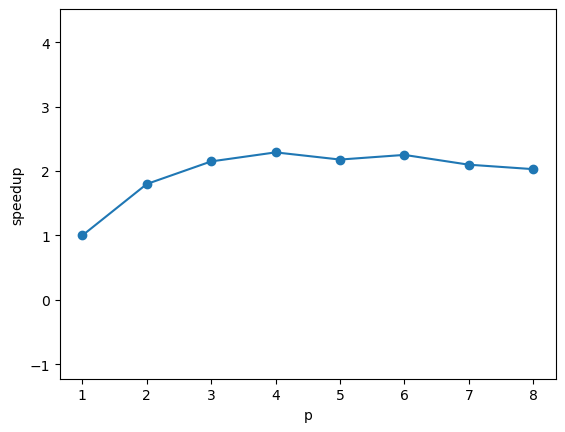

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(df['p'], df['speedup'])
plt.plot(df['p'], df['speedup'])
#plt.axvline(x=0, c="black", label="x=0")
#plt.axhline(y=0, c="black", label="y=0")
#plt.xlim([0, 10])
#plt.ylim([0, 10])
plt.axis('equal')
plt.ylabel('speedup')
plt.xlabel('p')
plt.show()


A interpretação do gráfico nos permite delinear conclusões interessantes sobre a paralelização tanto do ponto de vista do software quanto do hardware. Outros elementos que podem influenciar o desempenho incluem o tamanho e a quantidade de chunks.